In [1]:
import pandas as pd
from datetime import datetime, timedelta
%matplotlib inline
import json
import matplotlib.pyplot as plt
import pickle

In [2]:
complete_df = pd.read_csv("data/116_edit",sep = "\t" , header = 0)
# del complete_df.index.name
# complete_df = complete_df.set_index("raw_index")
complete_df.head()

,raw_index,route,licence_plate_number,calibrated_time,longitude,latitude,delta_lon,delta_lat,delta_time
0,19,116,粤E19204,2015-07-01 00:01:35,113.14631,23.02181,0.0,0.0,5
1,39,116,粤E19204,2015-07-01 00:01:40,113.14631,23.02181,0.0,0.0,5
2,57,116,粤E19204,2015-07-01 00:01:45,113.14631,23.02181,0.0,0.0,5
3,82,116,粤E19204,2015-07-01 00:01:50,113.14631,23.02181,0.0,0.0,5
4,102,116,粤E19204,2015-07-01 00:01:55,113.14631,23.02181,0.0,0.0,5


In [3]:
# (pd.to_datetime(complete_df.calibrated_time[0]) - pd.to_datetime(complete_df.calibrated_time[1])).total_seconds()
complete_df['calibrated_time'] = pd.to_datetime(complete_df['calibrated_time'])

In [4]:
# type(complete_df['calibrated_time'][0])
# complete_df.head()
bus1 = complete_df[complete_df["licence_plate_number"] == "粤E19204"]
# bus1.head()
complete_df.licence_plate_number.describe()

count     8712493
unique         24
top       粤E19207
freq       482164
Name: licence_plate_number, dtype: object

In [5]:
# find out all points that the bus stopped for the minimal time
# it will take an hour to run
not_working = []
for plate in complete_df["licence_plate_number"].unique():
    bus1 = complete_df[complete_df["licence_plate_number"] == plate]
#     bus1 = bus1.reset_index(drop=True)
    first_index = bus1.index[0]
    last_loc = (bus1.loc[first_index]["longitude"], bus1.loc[first_index]["latitude"])
    caching = []
    for i in bus1.index:
        if bus1.loc[i]["longitude"] == last_loc[0] and bus1.loc[i]["latitude"] == last_loc[1]:
            caching.append(i)
#             print i
        else:
            if len(caching) > 1: # if 
                not_working.append(caching)
#                 print caching
            # reset the cache
            caching = [i]
            last_loc = (bus1.loc[i]["longitude"], bus1.loc[i]["latitude"])
            
    print str(plate)
#     break

print len(not_working)

粤E19204
粤E19207
粤E16952
粤E19205
粤E17022
粤E17035
粤E16977
粤E17002
粤E17027
粤E17005
粤E16979
粤E17031
粤E16963
粤E17033
粤E17180
粤E17021
粤E17017
粤E19212
粤E17012
粤E16960
粤E19209
粤E17032
粤E17039
粤E17169
460873


In [6]:
pickle.dump( not_working, open( "data/test.p", "wb" ) )
# not_working = pickle.load(open( "data/test.p", "rb" ))

In [7]:
len(not_working)

460873

## stop_index_15

In [8]:
stop_index_15 = [point[0] for point in not_working if (complete_df.loc[point[-1],"calibrated_time"] - complete_df.loc[point[0],"calibrated_time"]).total_seconds() > 15]

In [9]:
# len(stop_index_15)  136629
# len(not_working)   800000+
stop_loc_15_df = complete_df.loc[stop_index_15][["longitude","latitude"]]
stop_loc_15_df = stop_loc_15_df[(stop_loc_15_df["latitude"]>22.8)&
                          (stop_loc_15_df["longitude"]>113.00) &(stop_loc_15_df["longitude"]<113.2)]

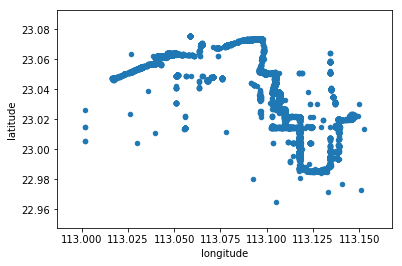

In [10]:
stop_loc_15_df.plot.scatter("longitude","latitude")


In [11]:
count = 0
stop_loc_15_df["nearby"] = 0
for i in stop_loc_15_df.index:
    count += 1
    if count%10000 == 0:
        print count
    stop_loc_15_df.loc[i,"nearby"] = stop_loc_15_df[(stop_loc_15_df["longitude"] > (stop_loc_15_df.loc[i,"longitude"] - 0.0002))&
                                              (stop_loc_15_df["longitude"] < (stop_loc_15_df.loc[i,"longitude"] + 0.0002))&
                                              (stop_loc_15_df["latitude"] > (stop_loc_15_df.loc[i,"latitude"]-0.0002))&
                                              (stop_loc_15_df["latitude"] < (stop_loc_15_df.loc[i,"latitude"]+0.0002))].shape[0]

# +-0.00005 8.5 meters
# +-0.0002 34 meters
# count
stop_loc_15_df.head()


10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000


,longitude,latitude,nearby
0,113.14631,23.02181,3068
1803,113.14628,23.02175,3369
1812,113.14631,23.02175,3355
1824,113.14630,23.02175,3372
1834,113.14626,23.02175,3385


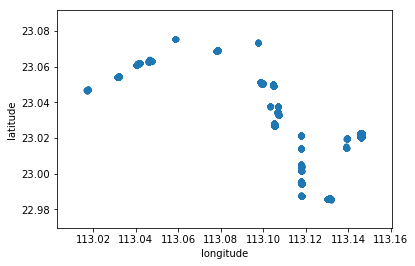

In [12]:
stop_loc_15_df_unique = stop_loc_15_df.drop_duplicates().sort_values("nearby",ascending = False)
# stop_loc_15_df_unique.head(30)
stop_loc_15_df_unique = stop_loc_15_df_unique[(stop_loc_15_df_unique["nearby"]<10000)&(stop_loc_15_df_unique["nearby"]>200)]
stop_loc_15_df_unique.plot.scatter("longitude","latitude")

In [64]:
# stop_loc_15_df_unique.shape
# from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
DB = DBSCAN(eps=0.0005, min_samples=200).fit(stop_loc_15_df_unique[["longitude","latitude"]])
# kmeans = KMeans(n_clusters=30, random_state=0).fit(stop_loc_15_df_unique[["longitude","latitude"]])

In [65]:
# print len(DB.components_.tolist())
# print len(DB.labels_.tolist())
# print len(DB.core_sample_indices_)
# DB.core_sample_indices_

loc = pd.DataFrame(DB.components_.tolist())
loc.index = DB.core_sample_indices_
loc.columns = ["lon","lat"]
# loc
lab = pd.DataFrame(DB.labels_)
lab.columns = ["label"]
# lab
df = pd.concat([loc, lab], axis=1)
df = df.dropna(axis=0, how='any')

In [68]:
stop_loc = df.groupby("label").mean()

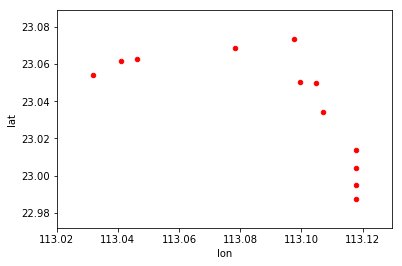

In [71]:
valid_stop = stop_loc[(stop_loc.lon<113.12)&(stop_loc.lon>113.02)]
# df.head()
valid_stop.plot(x="lon", y= "lat", kind = "scatter",color = "red")

In [72]:
valid_stop.to_csv("stoploc.csv")

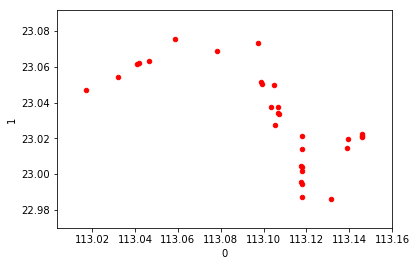

In [129]:
plt.figure()
# stop_loc.plot(x="lon",y="lat", kind = "scatter")
# stop_loc_df_unique.plot(x="longitude", y= "latitude", kind = "scatter",secondary_y=True, style='g' )
# with pd.plot_params.use('x_compat', True):
# a = 
pd.DataFrame(kmeans.cluster_centers_).plot(x=0, y= 1, kind = "scatter",color = "red")
# DB.components_
# pd.DataFrame(DB.core_sample_indices_)
# stop_loc_15_df_unique.shape

### Baidu Maps

In [107]:
stop_loc = pd.read_csv("data/116_stop.csv", header = 0)
# stop_loc.head()
stop_loc = stop_loc.reset_index()
stop_loc["lon"] = stop_loc["index"].apply(lambda x:float(x.split("\t")[1][1:]))
stop_loc["index"] = stop_loc["index"].apply(lambda x:x.split("\t")[0])
stop_loc["name\tlon"] = stop_loc["name\tlon"].apply(lambda x:float(x[:-1]))
stop_loc.columns = ["name","lat","lon"]


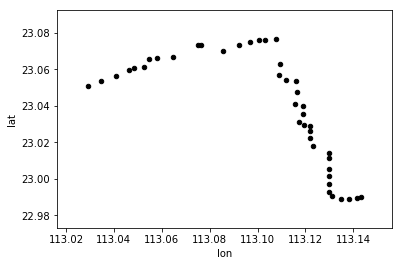

In [111]:
stop_loc.plot(x="lon",y="lat", kind = "scatter",  color = "black")

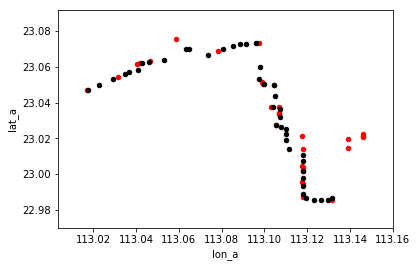

In [136]:
plt.figure()
a = pd.DataFrame(kmeans.cluster_centers_).plot(x=0, y= 1, kind = "scatter", color = "red")
stop_loc.plot(x="lon_a",y="lat_a", kind = "scatter",  color = "black", ax = a)

In [130]:
import math
smallest = 1000
best = None
for i in range(100):
    for j in range(100):
        stop_loc["lon_a"] = stop_loc["lon"] - 0.005 - i*0.0001
        stop_loc["lat_a"] = stop_loc["lat"] + 0.005 - j*0.0001
        score_sum = 0
        for index1 in stop_loc.index:
            
            temp_close = 0
            temp_distance = 1
            for index2 in stop_loc_hat.index:
                dist = (math.pow(stop_loc_hat.loc[index2,0]- stop_loc.loc[index1,"lon_a"], 2)+  
                    math.pow(stop_loc_hat.loc[index2,1]- stop_loc.loc[index1,"lat_a"], 2))
                if dist < temp_distance:
                    temp_distance = dist
                    temp_close = index2
            score_sum += temp_distance
        if score_sum < smallest:
            smallest = score_sum
            best = (i,j)
#             print (i,j)
#             print score_sum
    print i
print best

In [133]:
# stop_loc
stop_loc["lon_a"] = stop_loc["lon"] -0.0117
stop_loc["lat_a"] = stop_loc["lat"] -0.0035000000000000005

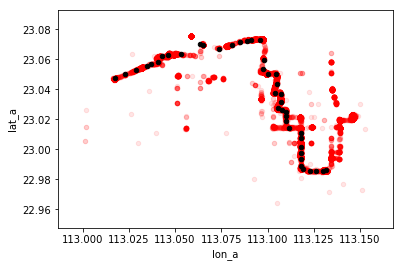

In [110]:
plt.figure()
# stop_loc.plot(x="lon",y="lat", kind = "scatter")
# stop_loc_df_unique.plot(x="longitude", y= "latitude", kind = "scatter",secondary_y=True, style='g' )
# with pd.plot_params.use('x_compat', True):
a = stop_loc_15_df.plot(x="longitude", y= "latitude", kind = "scatter", color = "red", alpha=0.1)
stop_loc.plot(x="lon_a",y="lat_a", kind = "scatter",  color = "black", ax = a)

### Scratch

#### stop_index_30

In [59]:
stop_index_30 = [point[0] for point in not_working if (complete_df.loc[point[-1],"calibrated_time"] - complete_df.loc[point[0],"calibrated_time"]).total_seconds() > 30]
stop_loc_30_df = complete_df.loc[stop_index_30][["longitude","latitude"]]
stop_loc_30_df = stop_loc_30_df[(stop_loc_30_df["latitude"]>22.8)&
                          (stop_loc_30_df["longitude"]>113.00) &(stop_loc_30_df["longitude"]<113.2)]

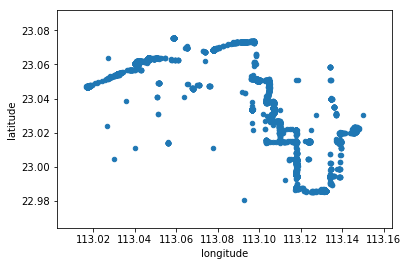

In [60]:
stop_loc_30_df.plot.scatter("longitude","latitude")


In [61]:
count = 0
stop_loc_30_df["nearby"] = 0
for i in stop_loc_30_df.index:
    count += 1
    if count%10000 == 0:
        print count
    stop_loc_30_df.loc[i,"nearby"] = stop_loc_30_df[(stop_loc_30_df["longitude"] > (stop_loc_30_df.loc[i,"longitude"] - 0.00005))&
                                              (stop_loc_30_df["longitude"] < (stop_loc_30_df.loc[i,"longitude"] + 0.00005))&
                                              (stop_loc_30_df["latitude"] > (stop_loc_30_df.loc[i,"latitude"]-0.00005))&
                                              (stop_loc_30_df["latitude"] < (stop_loc_30_df.loc[i,"latitude"]+0.00005))].shape[0]

# +-0.00005 17 meters
# count
stop_loc_30_df.head()

10000
20000
30000
40000


,longitude,latitude,nearby
0,113.14631,23.02181,124
1803,113.14628,23.02175,136
1824,113.14630,23.02175,123
1848,113.14630,23.02173,106
4070,113.14636,23.02170,44


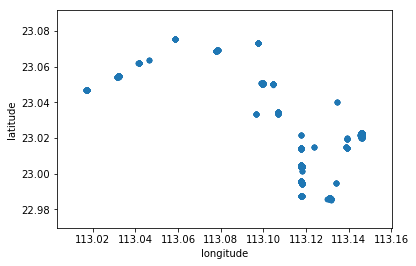

In [83]:
stop_loc_30_df_unique = stop_loc_30_df.drop_duplicates().sort_values("nearby",ascending = False)
# stop_loc_30_df_unique.head(30)
stop_loc_30_df_unique = stop_loc_30_df_unique[(stop_loc_30_df_unique["nearby"]<200)&(stop_loc_30_df_unique["nearby"]>20)]
stop_loc_30_df_unique.plot.scatter("longitude","latitude")

#### Between a range

In [84]:
stop_index_range = [point[0] for point in not_working if (complete_df.loc[point[-1],"calibrated_time"] - complete_df.loc[point[0],"calibrated_time"]).total_seconds() > 15 and (complete_df.loc[point[-1],"calibrated_time"] - complete_df.loc[point[0],"calibrated_time"]).total_seconds() < 60]
stop_loc_range_df = complete_df.loc[stop_index_range][["longitude","latitude"]]
stop_loc_range_df = stop_loc_range_df[(stop_loc_range_df["latitude"]>22.8)&
                          (stop_loc_range_df["longitude"]>113.00) &(stop_loc_range_df["longitude"]<113.2)]

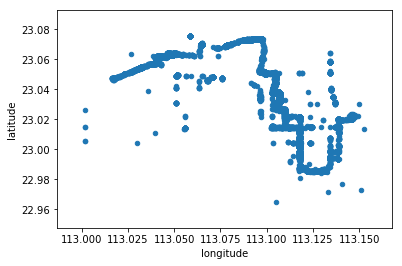

In [85]:
stop_loc_range_df.plot.scatter("longitude","latitude")


In [19]:
count = 0
stop_loc_range_df["nearby"] = 0
for i in stop_loc_range_df.index:
    count += 1
    if count%10000 == 0:
        print count
    stop_loc_range_df.loc[i,"nearby"] = stop_loc_range_df[(stop_loc_range_df["longitude"] > (stop_loc_range_df.loc[i,"longitude"] - 0.00005))&
                                              (stop_loc_range_df["longitude"] < (stop_loc_range_df.loc[i,"longitude"] + 0.00005))&
                                              (stop_loc_range_df["latitude"] > (stop_loc_range_df.loc[i,"latitude"]-0.00005))&
                                              (stop_loc_range_df["latitude"] < (stop_loc_range_df.loc[i,"latitude"]+0.00005))].shape[0]

# +-0.00005 17 meters
# count
stop_loc_range_df.head()

NameError: name 'stop_loc_range_df' is not defined

In [81]:
stop_loc_range_df_unique = stop_loc_range_df.drop_duplicates().sort_values("nearby",ascending = False)
# stop_loc_range_df_unique.head(30)
stop_loc_range_df_unique = stop_loc_range_df_unique[(stop_loc_range_df_unique["nearby"]<100)&(stop_loc_range_df_unique["nearby"]>50)]
stop_loc_range_df_unique.plot.scatter("longitude","latitude")

NameError: name 'stop_loc_range_df' is not defined

In [74]:
# stop_loc_df["count"] = 1
# stop_loc_df

# stop_loc_df.groupby([0,1]).ngroups
# pd.unique(stop_loc_df[[0,1]]).values.ravel()
# stop_loc_df.unique()

#### Baidu Maps API

In [92]:
from urllib2 import Request, urlopen, URLError

In [11]:
stop_loc = pd.read_csv("data/116_stop.csv", header = 0)
# stop_loc.head()
stop_loc = stop_loc.reset_index()
stop_loc["lon"] = stop_loc["index"].apply(lambda x:float(x.split("\t")[1][1:]))
stop_loc["index"] = stop_loc["index"].apply(lambda x:x.split("\t")[0])
stop_loc["name\tlon"] = stop_loc["name\tlon"].apply(lambda x:float(x[:-1]))
stop_loc["lon_a"] = stop_loc["lon"] -0.0117
stop_loc["lat_a"] = stop_loc["lat"] -0.0035000000000000005

,name lon
"�����й�����Ŧվ\t""113.14303","22.99001"""
"������\t""113.141601","22.9893"""
"������·\t""113.138105","22.988861"""
"����·��\t""113.134698","22.988911"""
"�غ�ܰͥ\t""113.130975","22.990432"""


In [63]:
stop_loc["lon_a"] = stop_loc["lon"] -0.0117
stop_loc["lat_a"] = stop_loc["lat"] -0.0035000000000000005
# -0.0117
# -0.0035000000000000005

In [65]:
stop_loc.columns = ["name","lat","lon",""]
stop_loc.head()


,name,lat,lon,lon_a,lat_a
0,�����й�����Ŧվ,22.990010,113.143030,113.131330,22.986510
1,������,22.989300,113.141601,113.129901,22.985800
2,������·,22.988861,113.138105,113.126405,22.985361
3,����·��,22.988911,113.134698,113.122998,22.985411
4,�غ�ܰͥ,22.990432,113.130975,113.119275,22.986932


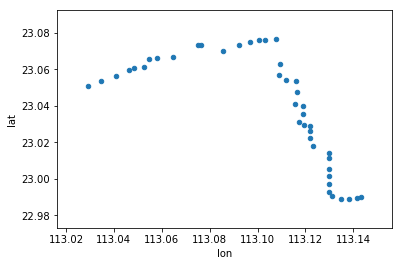

In [109]:
stop_loc.plot(x="lon",y="lat", kind = "scatter")

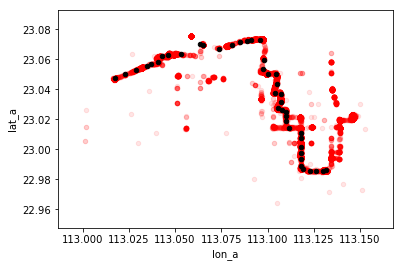

In [71]:
# stop_loc_df_unique.columns = ["lon","lat","nearby"]
plt.figure()
# stop_loc.plot(x="lon",y="lat", kind = "scatter")
# stop_loc_df_unique.plot(x="longitude", y= "latitude", kind = "scatter",secondary_y=True, style='g' )
# with pd.plot_params.use('x_compat', True):
a = stop_loc_15_df.plot(x="longitude", y= "latitude", kind = "scatter", color = "red", alpha=0.1)
stop_loc.plot(x="lon_a",y="lat_a", kind = "scatter",  color = "black", ax = a)
#     "longitude","latitude"

In [159]:
stop_loc_df_unique.head()

,longitude,latitude,nearby
raw_index,,,
8682025,113.13155,22.98566,299
2917945,113.14618,23.02153,299
1306389,113.14571,23.02163,299
6831855,113.01735,23.04670,299
8057153,113.14625,23.02163,298


In [18]:
stop_loc_15_df.shape()

(136627, 2)

In [23]:
# stop_loc.head()
stop_loc_15_df_unique.shape

(5972, 3)

Bus Stop Candidates

In [84]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=50, random_state=0).fit(stop_loc_15_df_unique[["longitude","latitude"]])

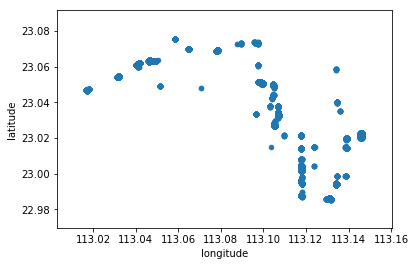

In [83]:
stop_loc_15_df_unique = stop_loc_15_df.drop_duplicates().sort_values("nearby",ascending = False)
# stop_loc_15_df_unique.head(30)
stop_loc_15_df_unique = stop_loc_15_df_unique[(stop_loc_15_df_unique["nearby"]<1000)&(stop_loc_15_df_unique["nearby"]>20)]
stop_loc_15_df_unique.plot.scatter("longitude","latitude")


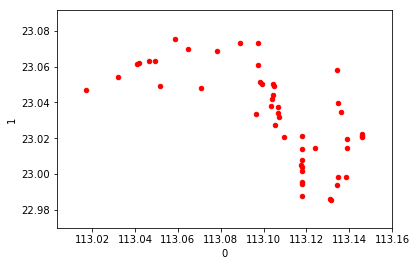

In [85]:
plt.figure()
# stop_loc.plot(x="lon",y="lat", kind = "scatter")
# stop_loc_df_unique.plot(x="longitude", y= "latitude", kind = "scatter",secondary_y=True, style='g' )
# with pd.plot_params.use('x_compat', True):
# a = 
pd.DataFrame(kmeans.cluster_centers_).plot(x=0, y= 1, kind = "scatter",color = "red")
# stop_loc_15_df.plot(x="longitude", y= "latitude", kind = "scatter", color = "red", alpha=0.1)
# stop_loc.plot(x="lon_a",y="lat_a", kind = "scatter",  color = "black", ax = a)
# pd.DataFrame(kmeans.cluster_centers_)

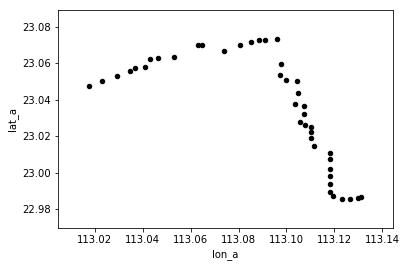

In [78]:
stop_loc.plot(x="lon_a",y="lat_a", kind = "scatter",  color = "black")
dbscan
large area
large threshold

In [51]:
stop_loc_hat = pd.DataFrame(kmeans.cluster_centers_)

In [62]:
(67, 85)

-0.005 - 67*0.0001

-0.0117

In [61]:
0.005 - 85*0.0001

-0.0035000000000000005

In [ ]:
-0.0117
-0.0035000000000000005